In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from sherpa.astro.io import read_arf, read_rmf
from sherpa.astro.instrument import RSPModelNoPHA
from sherpa.astro.utils import calc_model_sum
from sherpa.astro.xspec import XSpowerlaw, XSphabs, XSTBabs, XSwabs

plt.style.use("Solarize_Light2")

data_path = Path("data", "xmm")


def calc_ecf(rsp_model, elo, ehi):
    rate = rsp_model(0)
    
    e = 0.5 * (rsp_model.rmf.e_min + rsp_model.rmf.e_max)
    flux = e * rsp_model.model(rsp_model.rmf.e_min, rsp_model.rmf.e_max) << u.keV / u.s / u.cm**2 
    flux = flux.to(u.erg / u.s / u.cm**2).value
    
    mask_eband = np.logical_and(rsp_model.rmf.e_min >= elo, rsp_model.rmf.e_max <= ehi)
    
    return rate[mask_eband].sum() / flux[mask_eband].sum() / 1e11


ebands = {
    1: (0.2, 0.5),
    2: (0.5, 1.0),
    3: (1.0, 2.0),
    4: (2.0, 4.5),
    5: (4.5, 12.0),
    6: (0.2, 2.0),
    7: (2.0, 12.0),
    8: (0.2, 12.0),
    9: (0.5, 4.5),
    # "SOFT": (0.5, 2.0),
    # "HARD": (2.0, 10.0),
}   

# ECFs as in 3XMM/4XMM

I'm going to try to reproduce the ECFs given for the 3XMM/4XMM catalogues (see Rosen+2016, Webb+2022), following the metodology presented in Mateos+2009.

In [2]:
# Values for bands 1, 2, 3, 4, 5, 9 from Rosen+2016
# Values for bands 6, 7, 8 from https://www.cosmos.esa.int/web/xmm-newton/epic-upper-limits
ecf = {
    "PN": {
        # thin / medium / thick
        1: [9.52, 8.37, 5.11],  # 0.2-0.5 keV
        2: [8.12, 7.87, 6.05],  # 0.5-1.0 keV 
        3: [5.87, 5.77, 4.99],  # 1.0-2.0 keV 
        4: [1.95, 1.93, 1.83],  # 2.0-4.5 keV 
        5: [0.58, 0.58, 0.57],  # 4.5-12.0 keV 
        6: [7.39, 7.01, 5.41],  # 0.2-2.0 keV
        7: [1.11, 1.10, 1.06],  # 2.0-12.0 keV 
        8: [3.32, 3.19, 2.59],  # 0.2-12.0 keV
        9: [4.56, 4.46, 3.76],  # 0.5-4.5 keV
    },
    "M1": {
        1: [1.73, 1.53, 1.00],
        2: [1.75, 1.70, 1.38],
        3: [2.04, 2.01, 1.79],
        4: [0.74, 0.73, 0.70],
        5: [0.15, 0.15, 0.14],
        6: [1.93, 1.85, 1.53],
        7: [0.38, 0.38, 0.37],
        8: [0.93, 0.90, 0.78],        
        9: [1.38, 1.36, 1.20],
    },
    "M2": {
        1: [1.73, 1.52, 0.99],
        2: [1.76, 1.71, 1.39],
        3: [2.04, 2.01, 1.79],
        4: [0.74, 0.73, 0.70],
        5: [0.15, 0.15, 0.15],
        6: [1.93, 1.85, 1.53],
        7: [0.39, 0.39, 0.37],
        8: [0.94, 0.91, 0.78],        
        9: [1.39, 1.36, 1.21],
    }
}

According to Rosen+2016, temporal variations in the RMFs for the PN detector are negligible. Mateos+2009 uses the FullFrame mode. For on axis positions, these are the available PN RMFs:


In [3]:
rmfs_path = data_path / "rmfs"

pn_rmf_e1_path = rmfs_path / "epn_e1_ff20_sdY9_v21.0.rmf"
pn_rmf_e2_path = rmfs_path / "epn_e2_ff20_sdY9_v21.0.rmf"
pn_rmf_e3_path = rmfs_path / "epn_e3_ff20_sdY9_v21.0.rmf"
pn_rmf_e4_path = rmfs_path / "epn_e4_ff20_sdY9_v21.0.rmf"

# single pattern only. This is used for the 0.2-0.5 keV band, I think
pn_rmf_e1_singles_path = rmfs_path / "epn_e1_ff20_sY9_v21.0.rmf"
pn_rmf_e2_singles_path = rmfs_path / "epn_e2_ff20_sY9_v21.0.rmf"
pn_rmf_e3_singles_path = rmfs_path / "epn_e3_ff20_sY9_v21.0.rmf"
pn_rmf_e4_singles_path = rmfs_path / "epn_e4_ff20_sY9_v21.0.rmf"

In [4]:
# Source model, as in Rossen+2016
po = XSpowerlaw("po")
po.PhoIndex = 1.7

galabs = XSphabs("galabs")
# galabs = XSwabs("galabs")
# galabs = XSTBabs("galabs")
galabs.nH = 3e20 / 1e22

model = galabs * po

In [5]:
filters = ["Thin", "Medium", "Thick"]

arfs_path = data_path / "arfs"
rmfs_path = data_path / "rmfs"

myecf = {"PN": {}}

epoch = "e2"
for key, eband in ebands.items():
    myecf["PN"][key] = []
    
    for filter in filters:
        rmf = read_rmf(str(rmfs_path / f"epn_{epoch}_ff20_sdY9_v21.0.rmf"))
        arf = read_arf(str(arfs_path / f"{filter}_PN.arf"))
        rsp_model = RSPModelNoPHA(arf, rmf, model)

        myecf["PN"][key].append(calc_ecf(rsp_model, eband[0], eband[1]))

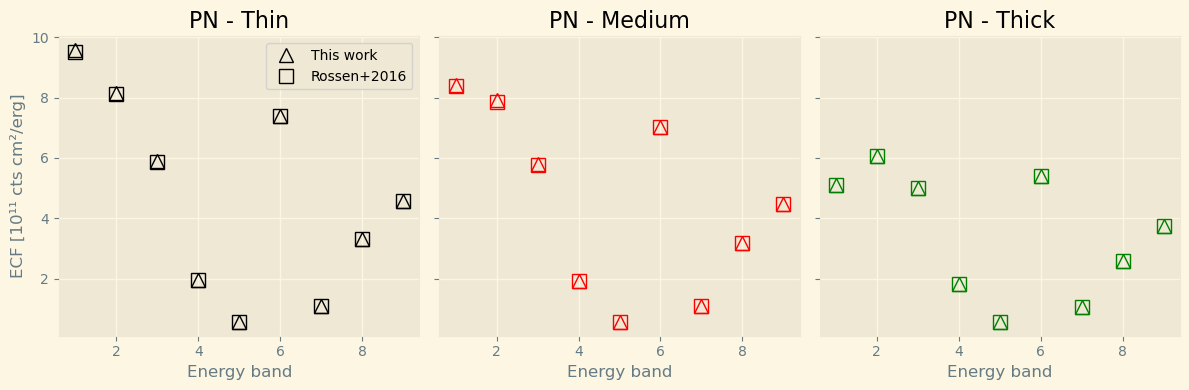

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for eband in ebands:
    if eband == 1:
        label1 = "This work"
        label2 = "Rossen+2016"
    else:
        label1 = "_This work"
        label2 = "_Rossen+2016"

    axes[0].set_title("PN - Thin")
    axes[0].plot(eband, myecf["PN"][eband][0], "k^", ms=10, markerfacecolor="none", label=label1)
    axes[0].plot(eband, ecf["PN"][eband][0], "ks", ms=10, markerfacecolor="none", label=label2)
    axes[0].set_xlabel("Energy band")
    axes[0].set_ylabel("ECF [10¹¹ cts cm²/erg]")

    axes[1].set_title("PN - Medium")
    axes[1].plot(eband, myecf["PN"][eband][1], "r^", ms=10, markerfacecolor="none")
    axes[1].plot(eband, ecf["PN"][eband][1], "rs", ms=10, markerfacecolor="none")
    axes[1].set_xlabel("Energy band")

    axes[2].set_title("PN - Thick")
    axes[2].plot(eband, myecf["PN"][eband][2], "g^", ms=10, markerfacecolor="none")
    axes[2].plot(eband, ecf["PN"][eband][2], "gs", ms=10, markerfacecolor="none")
    axes[2].set_xlabel("Energy band")

axes[0].legend()

plt.tight_layout()
plt.show()

In [7]:
myecf["M1"] = {}

epoch = "e13"
for key, eband in ebands.items():
    myecf["M1"][key] = []
    
    for filter in filters:
        rmf = read_rmf(str(rmfs_path / f"m1_{epoch}_im_pall_o.rmf"))
        arf = read_arf(str(arfs_path / f"{filter}_M1.arf"))
        rsp_model = RSPModelNoPHA(arf, rmf, model)

        myecf["M1"][key].append(calc_ecf(rsp_model, eband[0], eband[1]))

/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/x

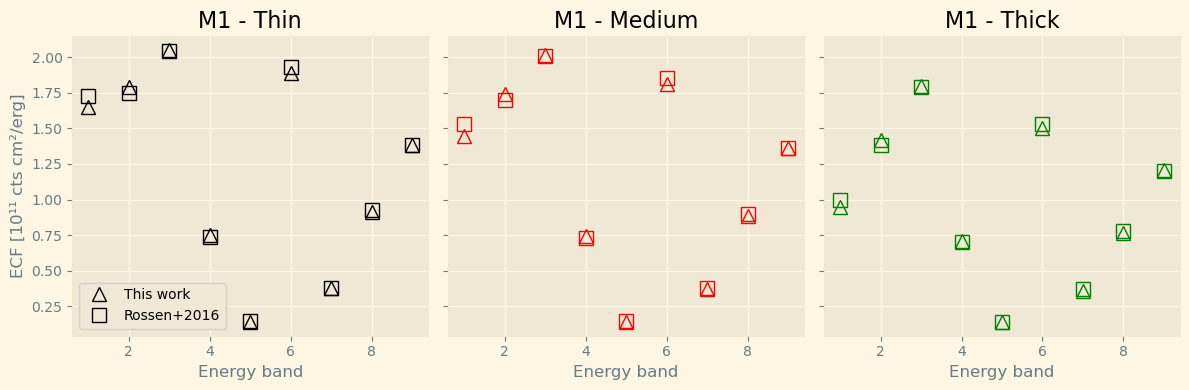

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for eband in ebands:
    if eband == 1:
        label1 = "This work"
        label2 = "Rossen+2016"
    else:
        label1 = "_This work"
        label2 = "_Rossen+2016"

    axes[0].set_title("M1 - Thin")
    axes[0].plot(eband, myecf["M1"][eband][0], "k^", ms=10, markerfacecolor="none", label=label1)
    axes[0].plot(eband, ecf["M1"][eband][0], "ks", ms=10, markerfacecolor="none", label=label2)
    axes[0].set_xlabel("Energy band")
    axes[0].set_ylabel("ECF [10¹¹ cts cm²/erg]")

    axes[1].set_title("M1 - Medium")
    axes[1].plot(eband, myecf["M1"][eband][1], "r^", ms=10, markerfacecolor="none")
    axes[1].plot(eband, ecf["M1"][eband][1], "rs", ms=10, markerfacecolor="none")
    axes[1].set_xlabel("Energy band")

    axes[2].set_title("M1 - Thick")
    axes[2].plot(eband, myecf["M1"][eband][2], "g^", ms=10, markerfacecolor="none")
    axes[2].plot(eband, ecf["M1"][eband][2], "gs", ms=10, markerfacecolor="none")
    axes[2].set_xlabel("Energy band")

axes[0].legend()

plt.tight_layout()
plt.show()

In [9]:
myecf["M2"] = {}

epoch = "e13"
for key, eband in ebands.items():
    myecf["M2"][key] = []
    
    for filter in filters:
        rmf = read_rmf(str(rmfs_path / f"m2_{epoch}_im_pall_o.rmf"))
        arf = read_arf(str(arfs_path / f"{filter}_M2.arf"))
        rsp_model = RSPModelNoPHA(arf, rmf, model)

        myecf["M2"][key].append(calc_ecf(rsp_model, eband[0], eband[1]))

/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/x

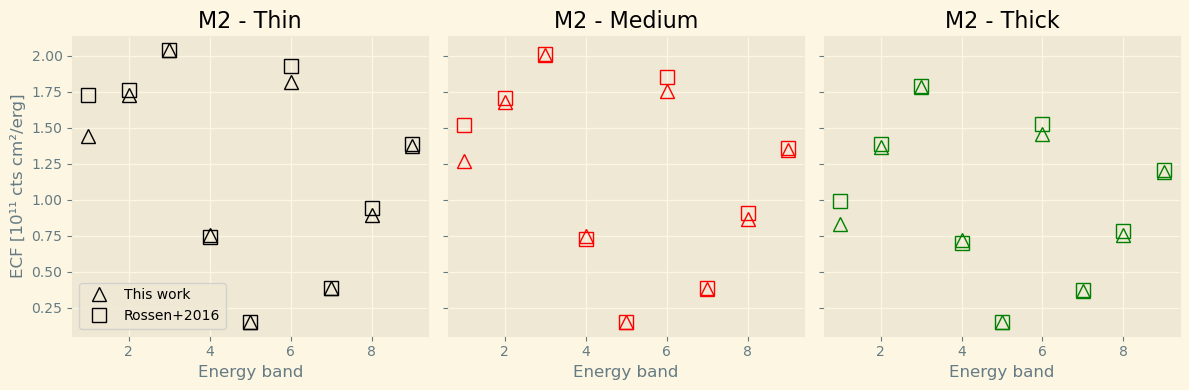

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for eband in ebands:
    if eband == 1:
        label1 = "This work"
        label2 = "Rossen+2016"
    else:
        label1 = "_This work"
        label2 = "_Rossen+2016"

    axes[0].set_title("M2 - Thin")
    axes[0].plot(eband, myecf["M2"][eband][0], "k^", ms=10, markerfacecolor="none", label=label1)
    axes[0].plot(eband, ecf["M2"][eband][0], "ks", ms=10, markerfacecolor="none", label=label2)
    axes[0].set_xlabel("Energy band")
    axes[0].set_ylabel("ECF [10¹¹ cts cm²/erg]")

    axes[1].set_title("M2 - Medium")
    axes[1].plot(eband, myecf["M2"][eband][1], "r^", ms=10, markerfacecolor="none")
    axes[1].plot(eband, ecf["M2"][eband][1], "rs", ms=10, markerfacecolor="none")
    axes[1].set_xlabel("Energy band")

    axes[2].set_title("M2 - Thick")
    axes[2].plot(eband, myecf["M2"][eband][2], "g^", ms=10, markerfacecolor="none")
    axes[2].plot(eband, ecf["M2"][eband][2], "gs", ms=10, markerfacecolor="none")
    axes[2].set_xlabel("Energy band")

axes[0].legend()

plt.tight_layout()
plt.show()